In [1]:
!pwd ## checkout if we are working under the correct directory

/Users/tiany4/Documents/CellsWells


In [2]:
import networkx as nx
from pathlib import Path
from build_graph import build_graph_from_raw
from data import GNNDataset,nx_to_tg_graph,process_feature,GNNgraphSampler
from models import GNN_pred

## Generate nx Graphs from raw data

In [3]:
# directory names
raw_dir = "data/Features_DSRT_small_regions"
graph_dir = "data/graphs_from_wells"

In [4]:
import os
from pathlib import Path
from build_graph import build_graph_from_raw  # the module to create a networkx graph
import networkx as nx

In [5]:
# generate nx graphs from raw data
if not os.path.exists(graph_dir): 
    os.mkdir(graph_dir)
    for file_name in os.listdir(raw_dir):
        file_path = Path(raw_dir, file_name)
        G = build_graph_from_raw(file_path,max_dist=70) # nodes with distance less than max_dist is considered as connected
        nx.write_gpickle(G, os.path.join(graph_dir, "%s.gpkl" % file_name[:-4]))

In [6]:
# check out file names
for file in os.listdir(graph_dir)[0:3]:
    print(file)
    file_path = Path(graph_dir, file)
    G = nx.read_gpickle(file_path)

p1_wL17_t1_m1_c0_z0_l1_o0.gpkl
p1_wE16_t1_m1_c0_z0_l1_o0.gpkl
p1_wM11_t1_m1_c0_z0_l1_o0.gpkl


In [7]:
# checkout node features. NOTE: to add more features, please modify the build_graph.py module. 
G.nodes()[0]

{'coord': array([7.97402832e+03, 9.53681543e+03, 8.89972878e+00]),
 'marker': array([108.79403687, 111.72982025, 650.32147217, 112.39523315,
        110.50389099]),
 'size': array([76034.        , 27187.88671875])}

In [8]:
G.edges()

EdgeView([(1, 2), (2, 3), (4, 5), (10, 11), (10, 16), (11, 16), (19, 21), (20, 23), (23, 24)])

In [9]:
# checkout edge features: node pair distance and encoded edge_type, 1 means far, 0 means close 
# for details, please checkout build_graph.py
G.edges()[(1,2)]

{'distance': 53.68262727742516, 'edge_type': 1}

In [10]:
node_features=["size", "marker", "coord"],
edge_features=["edge_type", "distance"],

In [11]:
G.edges

EdgeView([(1, 2), (2, 3), (4, 5), (10, 11), (10, 16), (11, 16), (19, 21), (20, 23), (23, 24)])

## Generate tensor graphs from nx graphs

In [12]:
# from data import GNNDataset,nx_to_tg_graph,process_feature,GNNgraphSampler
from data import nx_to_tg_graph,GNNDataset,GNNgraphSampler
import torch

In [13]:
tensor_dir = 'data/tensor_graphs'

In [14]:
# generate nx graphs from raw data
if not os.path.exists(tensor_dir): 
    os.mkdir(tensor_dir)
    for file in os.listdir(graph_dir):
        graph_path = os.path.join(graph_dir, file)
        G = nx.read_gpickle(graph_path)
        data = nx_to_tg_graph(G)
        torch.save(data, os.path.join(tensor_dir,'%s.gpt' % file[:-5]))


In [15]:
# check out file names
for file in os.listdir(tensor_dir)[0:3]:
    print(file)
    file_path = Path(tensor_dir, file)
    data = torch.load(file_path)

p1_wD13_t1_m1_c0_z0_l1_o0.gpt
p1_wA12_t1_m1_c0_z0_l1_o0.gpt
p1_wM2_t1_m1_c0_z0_l1_o0.gpt


In [16]:
# checkout tensor data which is standard input for GNN  ( x contains node features, y contains nodel label).
# for details/modification, please checkout the data.py module.
data.keys

['y', 'num_nodes', 'edge_attr', 'edge_index', 'x']

## Customized standard torch.geometric dataset and dataloader

In [17]:
from data import GNNDataset,GNNgraphSampler
from utils import CHANNEL_MARKERS

In [18]:
from utils import CHANNEL_MARKERS
dataset = GNNDataset(root="data",  
                     node_features=[ 'size','marker', 'coord'],
                     edge_features=['edge_type', 'distance'],
                     channel_markers=CHANNEL_MARKERS)

In [19]:
dataset.channel_markers  ## channels used for demo

['CELL INTENSITY-MEAN Alexa 488',
 'CELL INTENSITY-MEAN Alexa 647',
 'CELL INTENSITY-MEAN Brightfield',
 'CELL INTENSITY-MEAN Cy3',
 'CELL INTENSITY-MEAN Hoechst 33342']

In [20]:
dataset.node_feature_names 

['area',
 'volume',
 'marker-CELL INTENSITY-MEAN Alexa 488',
 'marker-CELL INTENSITY-MEAN Alexa 647',
 'marker-CELL INTENSITY-MEAN Brightfield',
 'marker-CELL INTENSITY-MEAN Cy3',
 'marker-CELL INTENSITY-MEAN Hoechst 33342',
 'coord-x',
 'coord-y',
 'coord-z']

In [21]:
dataset.edge_feature_names

['edge_type', 'distance']

In [22]:
# customized dataloader
data_iter = GNNgraphSampler(dataset, 
                                 selected_inds=None,
                                     batch_size=1,
                                     num_graphs_per_segment=10,
                                     steps_per_segment=1000)

batch = next(data_iter)

Initiate data loader, subgraph source: None


**Check out a single batch, for the time being:**

batch.x contains node features: 'area',
 'volume',
 'marker-CELL INTENSITY-MEAN Alexa 488',
 'marker-CELL INTENSITY-MEAN Alexa 647',
 'marker-CELL INTENSITY-MEAN Brightfield',
 'marker-CELL INTENSITY-MEAN Cy3',
 'marker-CELL INTENSITY-MEAN Hoechst 33342',
 'coord-x',
 'coord-y',
 'coord-z'.

 batch.edge_attr contains edge features: 'edge type', 'distance' 


batch.y contains nodel labels: 'marker-CELL INTENSITY-MEAN Alexa 488',
 'marker-CELL INTENSITY-MEAN Alexa 647',
 'marker-CELL INTENSITY-MEAN Brightfield',
 'marker-CELL INTENSITY-MEAN Cy3',
 'marker-CELL INTENSITY-MEAN Hoechst 33342'.


for details/modification, please checkout/edit the data.py module.

In [23]:
batch.keys

['y', 'num_nodes', 'batch', 'edge_attr', 'edge_index', 'ptr', 'x']

## Demo a GNN model training

Train a GNN model to do channel marker prediction. The main objective is to obtain node embeddings.

In [24]:
from models import GNN_pred   ## The module where models are defined

In [25]:
 model_kwargs = {
        'num_layer': 3, 
        'num_node_type': None,
        'num_feat': dataset[0].x.shape[1],
        'emb_dim': 512, 
        'num_node_tasks': 5,
        'num_graph_tasks': 0, 
        'node_embedding_output': 'last', 
        'drop_ratio': 0.25, 
        'graph_pooling': "max", 
        'gnn_type': "gin",
    }

In [26]:
model = GNN_pred(**model_kwargs)

In [27]:
# checkout model structure: linear embedding layer -> 3 GINConv layers 
#                         -> batch norm layers -> MLP head(for channel markers prediction) 

# Note: linear embedding layer combines node embeddings and edge embeddings, i.e. both node features and edge features will be used as input to the model. for details/modifications, please checkout models.py module.
# 
model 

GNN_pred(
  (gnn): GNN(
    (feat_embedding): Linear(in_features=10, out_features=512, bias=True)
    (gnns): ModuleList(
      (0): GINConv()
      (1): GINConv()
      (2): GINConv()
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (node_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [28]:
import torch.nn as nn
node_task_criterion = nn.MSELoss() ## using MSE as loss

In [29]:
device ='cpu'
# training
num_iterations = 300
optimizer = torch.optim.Adam(model.parameters()) 
losses = []
for i_iter in range(int(num_iterations)):
    batch = next(data_iter)
    batch = batch.to(device)
    batch_pred = model(batch)[0] 
    batch_y = batch.y.float() 
    loss = node_task_criterion(batch_pred,batch_y)
    losses.append(loss.detach())

    loss.backward()
    optimizer.step()
    model.zero_grad()

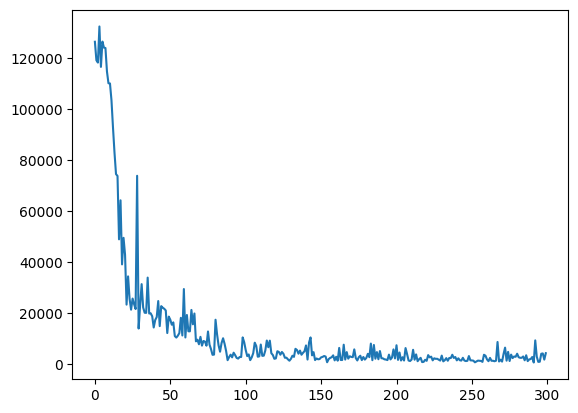

In [30]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [31]:
# By setting return_node_embedding=True, we can obtain node embeddings.
# This is an example for the first graph in the dataset.
embeddings = model(dataset[0],return_node_embedding=True)[1]
embeddings.shape

torch.Size([96, 512])

For further node embedding clustering/analysis, maybe we can try the method described in https://www.biorxiv.org/content/10.1101/2022.05.12.491707v1.full.pdf page20